This research presents preliminary findings and is being distributed to interested readers solely to stimulate discussion and elicit comments.

Notes: MCC vs Accuracy, source: https://towardsdatascience.com/the-best-classification-metric-youve-never-heard-of-the-matthews-correlation-coefficient-3bf50a2f3e9a

    TODO: Intro Para on data for training and testing 
    TODO: Explain CAMELS ratios
    TODO: Explain MCC and why it is important for imbalanced samples like this one
    TODO: Add timer to the Grid Search 
    TODO: Plot the tree and/or feature importances

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, cross_val_predict, validation_curve, GridSearchCV
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report, precision_recall_curve 
from sklearn.metrics import precision_recall_curve, roc_curve, matthews_corrcoef
from sklearn.ensemble import GradientBoostingClassifier
%matplotlib inline
# Needed for decision tree visualization
import pydotplus
from IPython.display import Image

### 1. Preprocessing

In [2]:
file_path = "data/camel_data_after2010Q3.csv"
banks_df = pd.read_csv(file_path, index_col=0)

Check if there are any missing values and drop `null`

In [3]:
banks_df.dropna(inplace=True)

Show the features of failed banks (Target of 1) and count them

In [4]:
banks_df.loc[banks_df.Target == 1].count()

AsOfDate    137
Target      137
EQTA        137
EQTL        137
LLRTA       137
LLRGL       137
OEXTA       137
INCEMP      137
ROA         137
ROE         137
TDTL        137
TDTA        137
TATA        137
dtype: int64

Take a copy of predictors and store in X, count all instances available.

In [5]:
X = banks_df[['EQTA', 'EQTL', 'LLRTA', 'LLRGL', 'OEXTA', 'INCEMP', 'ROA', 'ROE', 'TDTL', 'TDTA', 'TATA']].copy()
len(X)

7014

Define the target vector y and reshape it as well.

In [6]:
y = banks_df["Target"].values.reshape(-1, 1)

### 2. Developing basic GBM 

First train/test split, note `random_state=123` for the auditing purposes.

In [7]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=123)

Creating `StandardScaler` object and fitting, i.e. removing the mean and scaling to unit variance.

In [8]:
scaler = StandardScaler()
X_scaler = scaler.fit(X_train)

Transforming training and testing features data using the fitted scaler.

In [9]:
X_train_scaled = X_scaler.transform(X_train)
X_test_scaled = X_scaler.transform(X_test)

### 3. Optimizing Sensitivity (Minimizing Type II Error) with `GridSearch`

In [118]:
param_grid = {'learning_rate': [0.05, 0.1, 0.2, 0.5, 0.7, 0.8, 0.9], 
             "n_estimators" : [20, 30, 40, 50],
              "max_features": [2, 3, 4, 5],
              "max_depth" : [2, 3, 4, 5]} 

grid = GridSearchCV(GradientBoostingClassifier(), param_grid, scoring = 'recall', cv=5)
grid.fit(X, y.ravel());
grid.best_params_


{'learning_rate': 0.1, 'max_depth': 2, 'max_features': 5, 'n_estimators': 20}

Take note of these params below:

    `{'learning_rate': 0.1, 'max_depth': 2, 'max_features': 3, 'n_estimators': 30}`

**Take note of four evaluation metrics:**
- Accuracy: (TP + TN)/(TP + TN + FP + FN)
- Misclassification Rate: 1 - Accuracy or (FP + FN)/(TP + TN + FP + FN)
- Sensitivity (Recall or True Positive Rate): TP / (TP + FN)
- Specificity: TN / (TN + FN)
- False Positive Rate: FP / (TN + FP)
- Precision: TP / (TP + FP)

### 4. Evaluating the best GBM model

In [119]:
clf_best = GradientBoostingClassifier(n_estimators=20,
                                     learning_rate=0.1,
                                     max_features=5,
                                     max_depth=2,
                                     random_state=123)

clf_best.fit(X_train_scaled, y_train.ravel())
predictions = clf_best.predict(X_test_scaled)
print("Testing accuracy: {0:.3f}%".format(accuracy_score(predictions, y_test) * 100 ))
pd.DataFrame({"Prediction": predictions, "Actual": y_test.ravel()}).head(5)

Testing accuracy: 98.746%


,Prediction,Actual
0,0,0
1,0,0
2,0,0
3,0,0
4,0,0


In [66]:
clf_best = GradientBoostingClassifier(n_estimators=30,
                                     learning_rate=0.1,
                                     max_features=3,
                                     max_depth=2,
                                     random_state=123)

clf_best.fit(X_train_scaled, y_train.ravel())
predictions = clf_best.predict(X_test_scaled)
print("Testing accuracy: {0:.3f}%".format(accuracy_score(predicbtions, y_test) * 100 ))
pd.DataFrame({"Prediction": predictions, "Actual": y_test.ravel()}).head(5)

Testing accuracy: 98.461%


,Prediction,Actual
0,0,0
1,0,0
2,0,0
3,0,0
4,0,0


#### Check for Null Accuracy, i.e. always predicting majority class. Start with class distribution below:

In [120]:
y_true = pd.DataFrame(y_test, columns=['y_true'])
y_true["y_true"].value_counts()

0    1725
1      29
Name: y_true, dtype: int64

In [121]:
print('Calculate the percentage of ones: {0:.3f}%'.format(y_true["y_true"].mean() * 100))

Calculate the percentage of ones: 1.653%


In [122]:
print('Calculate Null accuracy for binary classification: {0:.3f}%'.format(
    max(y_true["y_true"].mean(), 1 - y_true["y_true"].mean()) *100))

Calculate Null accuracy for binary classification: 98.347%


#### Plot precision and recall trade-off over thresholds

Average precision-recall score: 0.66


Text(0.5, 1.0, '2-class Precision-Recall curve: Avg. Precision=0.66')

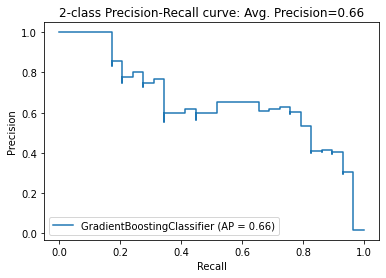

In [123]:
y_score = clf_best.decision_function(X_test_scaled)

from sklearn.metrics import average_precision_score
average_precision = average_precision_score(y_test, y_score)

print('Average precision-recall score: {0:0.2f}'.format(
      average_precision))

from sklearn.metrics import plot_precision_recall_curve
import matplotlib.pyplot as plt

disp = plot_precision_recall_curve(clf_best, X_test_scaled, y_test)
disp.ax_.set_title('2-class Precision-Recall curve: '
                   'Avg. Precision={0:0.2f}'.format(average_precision))

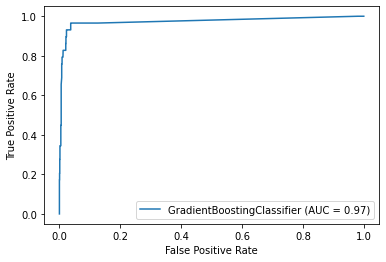

In [124]:
from sklearn.metrics import plot_roc_curve
clf_best_disp = plot_roc_curve(clf_best, X_test_scaled, y_test)
clf_best_disp.plot(ax=ax, alpha=0.8)
plt.show()


#### Generate the confusion matrix

In [125]:
pd.DataFrame(confusion_matrix(y_test, predictions), index=["True 0", "True 1"], 
             columns=["Predicted 0", "Predicted 1"])

,Predicted 0,Predicted 1
True 0,1712,13
True 1,9,20


In [126]:
print( "Total Actual Survived: ", 1707 + 18)
print("Total Actual Failed: ", 9 + 20)

Total Actual Survived:  1725
Total Actual Failed:  29


In [127]:
tn, fp, fn, tp = confusion_matrix(y_test, predictions).ravel()
tn, fp, fn, tp

(1712, 13, 9, 20)

In [128]:
print("recall: {0:.2f}".format(tp/(tp+fn)))

recall: 0.69


#### Compute Matthews correlation (MCC)

In [129]:
matthews_corrcoef(y_test, predictions)
print("Matthews Correlation is {0:.3f}".format(matthews_corrcoef(y_test, predictions)))

Matthews Correlation is 0.640


#### Generate classification report

In [130]:
print("In-Sample Classification Report")
print(classification_report(y_test, predictions))

In-Sample Classification Report
              precision    recall  f1-score   support

           0       0.99      0.99      0.99      1725
           1       0.61      0.69      0.65        29

    accuracy                           0.99      1754
   macro avg       0.80      0.84      0.82      1754
weighted avg       0.99      0.99      0.99      1754



### 5. Analysing rules that were learned in training

#### Extracting rules and feature importances 

In [115]:
n_classes, n_estimators = clf_best.estimators_.shape

for c in range(n_classes):
    
    for t in range(n_estimators):
        
        dtree = clf_best.estimators_[c, t]
        rules_df = pd.DataFrame({
            'child_left': dtree.tree_.children_left,
            'child_right': dtree.tree_.children_right,
            'feature': dtree.tree_.feature,
            'threshold': dtree.tree_.threshold,
        })
rules_df.head()

,child_left,child_right,feature,threshold
0,1,8,1,-0.023284
1,2,5,6,-2.327335
2,3,4,9,1.581137
3,-1,-1,-2,-2.000000
4,-1,-1,-2,-2.000000


#### TODO: plot decision tree

### 6. Out-of-sample GBM testing 

In [131]:
pd.set_option('use_inf_as_na', True)

oos_reports = ['2010Q4', '2011Q1', '2011Q2', '2011Q3', '2011Q4', '2012Q1', '2012Q2', 
               '2012Q3', '2012Q4', '2019Q2']

for report in oos_reports:
    
    oos_df = pd.read_csv('oos/camel_data_after{}_OOS.csv'.format(report))
    oos_df.replace([np.inf, -np.inf], np.nan)
    oos_df.dropna(inplace=True)
    
    y_oos = oos_df['Target']
    X_oos = oos_df[['EQTA', 'EQTL', 'LLRTA', 'LLRGL', 'OEXTA', 'INCEMP', 'ROA', 'ROE', 
                    'TDTL', 'TDTA', 'TATA']].copy()
    X_oos_scaled = X_scaler.transform(X_oos) 
    
    predictions_oos = clf_best.predict(X_oos_scaled)
    mcc = np.round(matthews_corrcoef(y_oos, predictions_oos), 2)
    
    # Generate out-of-sample MCC and classification report 
    print("*" * 55, "\nMatthews Correlation (MCC) for {} is {}".format(report, mcc))
    print("*" * 55,"\nOut-of-sample (OOS) Classification Report for {}:".format(report))
    print(classification_report(y_oos, predictions_oos), "\n\n")
   
  

******************************************************* 
Matthews Correlation (MCC) for 2010Q4 is 0.66
******************************************************* 
Out-of-sample (OOS) Classification Report for 2010Q4:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      6779
           1       0.53      0.83      0.65        24

    accuracy                           1.00      6803
   macro avg       0.76      0.92      0.82      6803
weighted avg       1.00      1.00      1.00      6803
 


******************************************************* 
Matthews Correlation (MCC) for 2011Q1 is 0.49
******************************************************* 
Out-of-sample (OOS) Classification Report for 2011Q1:
              precision    recall  f1-score   support

           0       1.00      0.99      1.00      6713
           1       0.24      1.00      0.38        19

    accuracy                           0.99      6732
   macro avg       0.62 